# Business Analytics - Analytics Cup 21

In [81]:
# importing libaries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from collections import Counter


## Reading in the data

In [82]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()


Saving train_physicians_7_F.csv to train_physicians_7_F.csv


In [83]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()


Saving test_physicians_7_F.csv to test_physicians_7_F.csv


In [104]:
train = pd.read_csv("train_physicians_7_F.csv")

In [105]:
test = pd.read_csv("test_physicians_7_F.csv")

In [89]:
train.head()

,Physician_ID,State,Primary_Specialty,ownership_interest,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range
0,1,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,170.41,8
1,2,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,35030.52,45
2,3,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,462.42,12
3,4,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,13247.09,50
4,5,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,9079.72,18


In [90]:
test.head()

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,514.07,96
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,42697.24,68
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,256.09,16
3,46,MI,NaN,1614.34,64,Food and Beverage,1614.34,547.14,15
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,1557.50,96


In [ ]:
test.shape

(1000, 5)

In [106]:
train = train.set_index('Physician_ID')

In [107]:
# labels 
y_train = train["ownership_interest"][0:4000]

y_test = train["ownership_interest"][4001:5000]

print(y_train, y_test)

Physician_ID
1       0
2       0
3       0
4       0
5       0
       ..
5026    0
5027    0
5028    0
5029    0
5030    1
Name: ownership_interest, Length: 4000, dtype: int64 Physician_ID
5032    0
5033    0
5034    0
5035    0
5036    0
       ..
5995    0
5996    0
5997    0
5998    0
6000    0
Name: ownership_interest, Length: 788, dtype: int64


In [112]:
y_train.value_counts()

0    3759
1     241
Name: ownership_interest, dtype: int64

In [113]:
y_test.value_counts()

0    745
1     43
Name: ownership_interest, dtype: int64

In [114]:
train.columns

Index(['State', 'Primary_Specialty', 'ownership_interest', 'total_payments',
       'number_of_payments', 'nature', 'total_of_nature', 'range',
       'number_of_payment_range'],
      dtype='object')

In [119]:
# features (manually)
X_train = train[["total_payments","number_of_payments",'total_of_nature',"nature", 'range',
       'number_of_payment_range', "Primary_Specialty"]][0:4000]

X_test = train[["total_payments","number_of_payments",'total_of_nature',"nature", 'range',
       'number_of_payment_range', "Primary_Specialty"]][4001:5000]

## new data

In [ ]:
# this allows for accessing files stored in your google drive using the path "/gdrive/My Drive/"
# mounting google drive locally:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
df = pd.read_csv("/gdrive/My Drive/full_df.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,16,17,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing

In [ ]:
df.head()

,Unnamed: 0,Physician_ID,set,First_Name,Middle_Name,Last_Name,Name_Suffix,City,State,Zipcode,Country.x,Province,Primary_Specialty,License_State_1,License_State_2,License_State_3,License_State_4,License_State_5,Company_ID,Record_ID,Total_Amount_of_Payment_USDollars,Date,Number_of_Payments,Form_of_Payment_or_Transfer_of_Value,Nature_of_Payment_or_Transfer_of_Value,City_of_Travel,State_of_Travel,Country_of_Travel,Ownership_Indicator,Third_Party_Recipient,Charity,Third_Party_Covered,Contextual_Information,Related_Product_Indicator,Product_Code_1,Product_Code_2,Product_Code_3,Product_Type_1,Product_Type_2,Product_Type_3,Product_Name_1,Product_Name_2,Product_Name_3,Product_Category_1,Product_Category_2,Product_Category_3,Company_name,Company_state,Country.y
0,1,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,69,236420.0,15.13,09/11/2014,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,NaN,NaN,NaN,Drug or Biological,Drug or Biological,NaN,Myrbetriq,Vesicare,NaN,NaN,NaN,NaN,Astellas Pharma US Inc,IL,United States
1,2,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,450,22992.0,11.77,09/12/2013,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,5963058000,NaN,NaN,Drug or Biological,NaN,NaN,Osphena,NaN,NaN,NaN,NaN,NaN,Shionogi Inc,NJ,United States
2,3,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,550,1278340.0,20.78,05/10/2019,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,No,NaN,NaN,Yes,NaN,NaN,NaN,Device,NaN,NaN,HARMONIC Product Family,NaN,NaN,NaN,NaN,NaN,"Medical Device Business Services, Inc.",IN,United States
3,4,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,613,365090.0,23.74,04/09/2015,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,NaN,NaN,NaN,Device or Medical Supply,NaN,NaN,THINPREP,NaN,NaN,NaN,NaN,NaN,HOLOGIC INC,MA,United States
4,5,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,550,1278614.0,20.78,05/10/2019,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,No,NaN,NaN,Yes,NaN,NaN,NaN,Device,NaN,NaN,HARMONIC Product Family,NaN,NaN,NaN,NaN,NaN,"Medical Device Business Services, Inc.",IN,United States


In [ ]:
df.columns

Index(['Unnamed: 0', 'Physician_ID', 'set', 'First_Name', 'Middle_Name',
       'Last_Name', 'Name_Suffix', 'City', 'State', 'Zipcode', 'Country.x',
       'Province', 'Primary_Specialty', 'License_State_1', 'License_State_2',
       'License_State_3', 'License_State_4', 'License_State_5', 'Company_ID',
       'Record_ID', 'Total_Amount_of_Payment_USDollars', 'Date',
       'Number_of_Payments', 'Form_of_Payment_or_Transfer_of_Value',
       'Nature_of_Payment_or_Transfer_of_Value', 'City_of_Travel',
       'State_of_Travel', 'Country_of_Travel', 'Ownership_Indicator',
       'Third_Party_Recipient', 'Charity', 'Third_Party_Covered',
       'Contextual_Information', 'Related_Product_Indicator', 'Product_Code_1',
       'Product_Code_2', 'Product_Code_3', 'Product_Type_1', 'Product_Type_2',
       'Product_Type_3', 'Product_Name_1', 'Product_Name_2', 'Product_Name_3',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Company_name', 'Company_state', 'Countr

In [ ]:
# Set ID as the index of your data and then do the split, that way you will retain the ID value for all of your train and test data

df = df.set_index('Physician_ID')

In [ ]:
df.head()

,set,City,State,Primary_Specialty,License_State_1,License_State_2,License_State_3,License_State_4,License_State_5,Total_Payments,Ownership_Payments_Count,Ownership_Interest
Physician_ID,,,,,,,,,,,,
1,train,FORT PIERCE,FL,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,952.93,0,False
2,train,TOWSON,MD,Allopathic & Osteopathic Physicians|Anesthesio...,MD,NaN,NaN,NaN,NaN,120924.92,0,False
3,train,TROY,NY,Podiatric Medicine & Surgery Service Providers...,NY,NaN,NaN,NaN,NaN,3523.93,0,False
4,train,SAVANNAH,GA,Allopathic & Osteopathic Physicians|Internal M...,GA,SC,AL,NaN,NaN,26745.61,0,False
5,train,ALBUQUERQUE,NM,Allopathic & Osteopathic Physicians|Orthopaedi...,NM,NaN,NaN,NaN,NaN,25411.21,0,False


In [ ]:
df.columns

Index(['set', 'City', 'State', 'Primary_Specialty', 'License_State_1',
       'License_State_2', 'License_State_3', 'License_State_4',
       'License_State_5', 'Total_Payments', 'Ownership_Payments_Count',
       'Ownership_Interest'],
      dtype='object')

In [ ]:
# dimensionality of the df
df.shape

(1402250, 49)

In [ ]:
# pairwise correlations of the columns
df.corr()

,Unnamed: 0,Physician_ID,Province,Company_ID,Record_ID,Total_Amount_of_Payment_USDollars,Number_of_Payments,Product_Category_2,Product_Category_3
Unnamed: 0,1.000000,0.999901,NaN,-0.007077,-0.004893,0.000370,-0.001545,NaN,NaN
Physician_ID,0.999901,1.000000,NaN,-0.007202,-0.004926,0.000351,-0.001563,NaN,NaN
Province,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company_ID,-0.007077,-0.007202,NaN,1.000000,0.141562,0.005695,-0.007207,NaN,NaN
Record_ID,-0.004893,-0.004926,NaN,0.141562,1.000000,0.000280,-0.007403,NaN,NaN
Total_Amount_of_Payment_USDollars,0.000370,0.000351,NaN,0.005695,0.000280,1.000000,0.002332,NaN,NaN
Number_of_Payments,-0.001545,-0.001563,NaN,-0.007207,-0.007403,0.002332,1.000000,NaN,NaN
Product_Category_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ordinal/One-hot Encoding 

 
Link: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

Machine learning models require all input and output variables to be numeric.

This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model.  

Types of data:    
**Numerical data**. Variable or features that is only composed of numbers, such as integers or floating-point values  
**Nominal/Categorical Variable**. Variable comprises a finite set of discrete values with no relationship between values.  
**Ordinal Variable**. Variable comprises a finite set of discrete values with a ranked ordering between values.

A numerical variable can be converted to an ordinal variable by dividing the range of the numerical variable into bins and assigning values to each bin. For example, a numerical variable between 1 and 10 can be divided into an ordinal variable with 5 labels with an ordinal relationship: 1-2, 3-4, 5-6, 7-8, 9-10. This is called **discretization**.


The following variants exist:
* One-hot encoding (each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) value to the column)
* Ordinal encoding (=Integer Encoding) (each unique category value is assigned an integer value For example, “red” is 1, “green” is 2, and “blue” is 3)
* Label encoding (This approach is very simple and it involves converting each value in a column to a number)






**However, some algorithms can work with categorical data directly.**

For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation).

In [131]:
train.head()

,State,Primary_Specialty,ownership_interest,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range
Physician_ID,,,,,,,,,
1,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,170.41,8
2,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,35030.52,45
3,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,462.42,12
4,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,13247.09,50
5,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,9079.72,18


In [179]:
train.shape

(4789, 9)

In [132]:
# checking the column data types to figures out which attributes are categorical (object) and which ones numerical (int)
train.dtypes

State                       object
Primary_Specialty           object
ownership_interest           int64
total_payments             float64
number_of_payments           int64
nature                      object
total_of_nature            float64
range                      float64
number_of_payment_range      int64
dtype: object

In [133]:
cat_feature_mask = train.dtypes == object # boolean test (mask) of whether the col is of "object type" or not
cat_feature_mask

State                       True
Primary_Specialty           True
ownership_interest         False
total_payments             False
number_of_payments         False
nature                      True
total_of_nature            False
range                      False
number_of_payment_range    False
dtype: bool

In [134]:
# filter categorical columns using the mask and turn it into a list
cat_list = train.columns[cat_feature_mask].to_list()

cat_list

['State', 'Primary_Specialty', 'nature']

In [135]:
# removing a list element
cat_list.remove("State")

cat_list

['Primary_Specialty', 'nature']

In [166]:
train["Primary_Specialty"].unique()

array(['Obstetrics & Gynecology', 'Anesthesiology',
       'Podiatric Medicine & Surgery Service Providers',
       'Internal Medicine', 'Orthopaedic Surgery', 'Dental Providers',
       'Pediatrics', 'Surgery', 'Eye and Vision Services Providers',
       'Psychiatry & Neurology', 'Plastic Surgery',
       'Neurological Surgery', 'Dermatology', 'Emergency Medicine',
       'Ophthalmology', 'Family Medicine', 'Radiology', 'Otolaryngology',
       'Physical Medicine & Rehabilitation', 'Urology',
       'Preventive Medicine', 'Allergy & Immunology',
       'Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'Pain Medicine', 'Hospitalist', 'Colon & Rectal Surgery',
       'General Practice', 'Pathology', 'Oral & Maxillofacial Surgery',
       'Neuromusculoskeletal Medicine, Sports Medicine',
       'Chiropractic Providers', 'Nuclear Medicine',
       'Neuromusculoskeletal Medicine & OMM', 'Medical Genetics'],
      dtype=object)

In [169]:
train["Primary_Specialty"].unique().shape

(34,)

In [163]:
train["nature"].unique()

array(['Food and Beverage',
       'Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program',
       'Education', 'Consulting Fee', 'Travel and Lodging', 'Gift',
       'Honoraria',
       'Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program',
       'Current or prospective ownership or investment interest', 'Grant',
       'Royalty or License',
       'Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program',
       'Charitable Contribution'], dtype=object)

In [170]:
train["nature"].unique().shape

(13,)

In [257]:
# transforming the categorical columns to numerical values using a ONE HOT ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

data = train[cat_list]

# transform data
result_oh = pd.DataFrame(onehot_encoder.fit_transform(data))
print(result_oh)


       0    1    2    3    4    5    6   ...   40   41   42   43   44   45   46
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
4784  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4785  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4786  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4787  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4788  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0

[4789 rows x 47 columns]


In [258]:
# colnames of encoded features
onehot_encoder.get_feature_names()

array(['x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Chiropractic Providers', 'x0_Colon & Rectal Surgery',
       'x0_Dental Providers', 'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Medical Genetics', 'x0_Neurological Surgery',
       'x0_Neuromusculoskeletal Medicine & OMM',
       'x0_Neuromusculoskeletal Medicine, Sports Medicine',
       'x0_Nuclear Medicine', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Oral & Maxillofacial Surgery',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology',
       'x0_Radiology', 'x0_Surgery',
       'x0_Thoracic Surgery (Cardio

In [259]:
# renaming the encoded columns 
result_oh.columns = onehot_encoder.get_feature_names() 

result_oh

,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [260]:
# transforming the categorical columns to numerical values using an ORDINAL ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define ordinal encoding
##ordinal_encoder = OrdinalEncoder()

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

#data = train[cat_list]

# transform data
##result = pd.DataFrame(ordinal_encoder.fit_transform(data))
##print(result)



Adding the encoded columns to the training and test data

In [262]:
# merging the two dfs
train_final = pd.concat([train.reset_index(drop=True), result_oh], axis=1,)

train_final

,State,Primary_Specialty,ownership_interest,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,170.41,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,35030.52,45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,462.42,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,13247.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,9079.72,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,TX,Family Medicine,0,5528.35,390,Food and Beverage,5451.13,464.40,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4785,FL,Orthopaedic Surgery,0,19714.41,517,Food and Beverage,9265.08,5161.48,95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4786,FL,Urology,0,2946.90,162,Food and Beverage,2672.05,485.59,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4787,AR,Family Medicine,0,7870.

In [263]:
# dropping the categorical features that have been encoded
train_final = train_final.drop(["Primary_Specialty","nature", "State"], axis=1)



In [264]:
train_final.head()

,ownership_interest,total_payments,number_of_payments,total_of_nature,range,number_of_payment_range,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,0,952.93,47,842.44,170.41,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,120924.92,154,45190.70,35030.52,45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3523.93,132,3523.93,462.42,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,26745.61,411,18011.81,13247.09,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,25411.21,98,8792.00,9079.72,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


train test split

In [190]:
# labels 
y_train = train_final["ownership_interest"][0:4000]

y_test = train_final["ownership_interest"][4001:5000]

print(y_train, y_test)

0       0
1       0
2       0
3       0
4       0
       ..
3995    0
3996    0
3997    0
3998    0
3999    1
Name: ownership_interest, Length: 4000, dtype: int64 4001    0
4002    0
4003    0
4004    0
4005    0
       ..
4784    0
4785    0
4786    0
4787    0
4788    0
Name: ownership_interest, Length: 788, dtype: int64


In [192]:
# features (manually)
X_train = train_final.drop(["ownership_interest"], axis=1)[0:4000]

X_test = train_final.drop(["ownership_interest"], axis=1)[4001:5000]
print(X_train, X_test)

      total_payments  number_of_payments  total_of_nature  ...   44   45   46
0             952.93                  47           842.44  ...  0.0  0.0  0.0
1          120924.92                 154         45190.70  ...  0.0  0.0  0.0
2            3523.93                 132          3523.93  ...  0.0  0.0  0.0
3           26745.61                 411         18011.81  ...  0.0  0.0  0.0
4           25411.21                  98          8792.00  ...  0.0  0.0  0.0
...              ...                 ...              ...  ...  ...  ...  ...
3995        15612.86                1169         15428.52  ...  0.0  0.0  0.0
3996         1194.67                  39          1170.18  ...  0.0  0.0  0.0
3997         7061.66                 218          5509.03  ...  0.0  0.0  0.0
3998         1921.75                 106          1900.90  ...  0.0  0.0  0.0
3999         9368.84                 764          8853.75  ...  0.0  0.0  0.0

[4000 rows x 52 columns]       total_payments  number_of_paymen

encoding test set

In [222]:
test.head()

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,514.07,96
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,42697.24,68
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,256.09,16
3,46,MI,NaN,1614.34,64,Food and Beverage,1614.34,547.14,15
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,1557.50,96


In [226]:
cat_feature_mask_ts = test.dtypes == object # boolean test (mask) of whether the col is of "object type" or not
cat_feature_mask_ts

Physician_ID               False
State                       True
Primary_Specialty           True
total_payments             False
number_of_payments         False
nature                      True
total_of_nature            False
range                      False
number_of_payment_range    False
dtype: bool

In [232]:
# filter categorical columns using the mask and turn it into a list
cat_list_ts = test.columns[cat_feature_mask_ts].to_list()

cat_list_ts

['State', 'Primary_Specialty', 'nature']

In [233]:
cat_list_ts.remove("State")


In [243]:
# transforming the categorical columns to numerical values using a ONE HOT ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

data = test[cat_list_ts]



# transform data
result_test_oh = pd.DataFrame(onehot_encoder.fit_transform(data))
print(result_test_oh)


      0    1    2    3    4    5    6   ...   32   33   34   35   36   37   38
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0
999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0

[1000 rows x 39 columns]


In [254]:
# colnames of encoded features
onehot_encoder.get_feature_names()

array(['x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics',
       'x0_Phlebology', 'x0_Physical Medicine & Rehabilitation',
       'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology',
       'x0_Radiology', 'x0_Surgery',
       'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program',

In [256]:
# renaming the encoded columns 
result_test_oh.columns = onehot_encoder.get_feature_names() 

result_test_oh

,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [237]:
test[cat_list_ts]

,Primary_Specialty,nature
0,Pain Medicine,Food and Beverage
1,Internal Medicine,Consulting Fee
2,Obstetrics & Gynecology,Food and Beverage
3,NaN,Food and Beverage
4,Internal Medicine,Food and Beverage
...,...,...
995,Internal Medicine,Compensation for services other than consultin...
996,Urology,Food and Beverage
997,Family Medicine,Food and Beverage
998,Urology,Food and Beverage


In [238]:
# detecting and counting missing values (NaNs)
test.isnull().sum()

Physician_ID                0
State                       0
Primary_Specialty          47
total_payments              0
number_of_payments          0
nature                      0
total_of_nature             0
range                       0
number_of_payment_range     0
dtype: int64

In [242]:
# mode class = Internal Medicine 
test["Primary_Specialty"].value_counts()

Internal Medicine                                     321
Family Medicine                                        97
Psychiatry & Neurology                                 67
Pediatrics                                             59
Obstetrics & Gynecology                                51
Eye and Vision Services Providers                      46
Dental Providers                                       44
Orthopaedic Surgery                                    43
Ophthalmology                                          36
Surgery                                                36
Urology                                                26
Otolaryngology                                         21
Podiatric Medicine & Surgery Service Providers         20
Anesthesiology                                         20
Dermatology                                            19
Physical Medicine & Rehabilitation                     15
Allergy & Immunology                                   15
Radiology     

In [240]:
# imputation of  NaN values with the most frequent class
test["Primary_Specialty"] = test["Primary_Specialty"].replace(np.nan, 'Internal Medicine', regex=True)

In [241]:
test.isnull().sum() # check

Physician_ID               0
State                      0
Primary_Specialty          0
total_payments             0
number_of_payments         0
nature                     0
total_of_nature            0
range                      0
number_of_payment_range    0
dtype: int64

In [265]:
# merging the two dfs
test_final = pd.concat([test.reset_index(drop=True), result_test_oh], axis=1,)

test_final

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,nature,total_of_nature,range,number_of_payment_range,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,514.07,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,42697.24,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,256.09,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,46,MI,Internal Medicine,1614.34,64,Food and Beverage,1614.34,547.14,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,1557.50,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5953,TN,Internal Medicine,175432.11,590,Compensation for services other than consultin...,124980.00,80041.72,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,5959,CA,Urology,2920.08,98,Food and Beverage,2109.56,1270.64,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,5964,OK,Family Medicine,1036.32,93,Food and Beverage,929.36,308.36,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
998,5972,TX,Urology,14156.35,285,Food and Beverage,6119.79,5015.32,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [266]:
# dropping the categorical features that have been encoded
test_final = test_final.drop(["Primary_Specialty","nature", "State"], axis=1)

test_final


,Physician_ID,total_payments,number_of_payments,total_of_nature,range,number_of_payment_range,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging
0,14,5775.53,539,5626.66,514.07,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,18,92123.24,584,39516.38,42697.24,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42,3159.49,180,3066.04,256.09,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,46,1614.34,64,1614.34,547.14,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,47,6494.00,296,6444.00,1557.50,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5953,175432.11,590,124980.00,80041.72,181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,5959,2920.08,98,2109.56,1270.64,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,5964,1036.32,93,929.36,308.36,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
998,5972,14156.35,285,6119.79,5015.32,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [330]:
enc_features = test_final.columns[1:test_final.columns.shape[0]]

enc_features

Index(['total_payments', 'number_of_payments', 'total_of_nature', 'range',
       'number_of_payment_range', 'x0_Allergy & Immunology',
       'x0_Anesthesiology', 'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, including serving as faculty

End encoding & preprocessing

In [ ]:
# frequency table
df["set"].value_counts()

train    1170030
test      232220
Name: set, dtype: int64

In [ ]:
# frequency table of the target variable -> imbalanced among classes
df["Ownership_Indicator"].value_counts()

No     1399846
Yes       2404
Name: Ownership_Indicator, dtype: int64

In [ ]:
# frequency table
df["Ownership_Payments_Count"].value_counts()

0     5700
1      141
2       33
3       19
4       14
5       10
8        5
12       5
14       5
13       5
9        4
15       4
27       4
7        3
19       3
29       3
22       3
20       3
16       3
10       3
6        2
49       2
18       2
11       2
76       1
63       1
59       1
43       1
39       1
31       1
24       1
32       1
36       1
44       1
88       1
75       1
92       1
23       1
62       1
38       1
21       1
25       1
34       1
33       1
41       1
79       1
Name: Ownership_Payments_Count, dtype: int64

In [ ]:
# labels 
y_train = df["Ownership_Interest"][df["set"] == "train"]

y_test = df["Ownership_Interest"][df["set"] == "test"]


In [ ]:
y_test.unique()

array([False])

In [ ]:
# features (manually)
X_train = df[["Total_Payments","Ownership_Payments_Count"]][df["set"] == "train"]

X_test = df[["Total_Payments","Ownership_Payments_Count"]][df["set"] == "test"]

In [120]:
# train test split (taking 70% of the labeled training data as the training set and and 30% of the labelled training data as a validation set
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123,shuffle=False)


print(X_train, X_test, y_train, y_test)

              total_payments  ...                               Primary_Specialty
Physician_ID                  ...                                                
1                     952.93  ...                         Obstetrics & Gynecology
2                  120924.92  ...                                  Anesthesiology
3                    3523.93  ...  Podiatric Medicine & Surgery Service Providers
4                   26745.61  ...                               Internal Medicine
5                   25411.21  ...                             Orthopaedic Surgery
...                      ...  ...                                             ...
5026                15612.86  ...                                 Family Medicine
5027                 1194.67  ...                               Internal Medicine
5028                 7061.66  ...                               Internal Medicine
5029                 1921.75  ...                          Psychiatry & Neurology
5030            

In [121]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 7), (788, 7), (4000,), (788,))

In [122]:
X_train.head()

,total_payments,number_of_payments,total_of_nature,nature,range,number_of_payment_range,Primary_Specialty
Physician_ID,,,,,,,
1,952.93,47,842.44,Food and Beverage,170.41,8,Obstetrics & Gynecology
2,120924.92,154,45190.70,Compensation for services other than consultin...,35030.52,45,Anesthesiology
3,3523.93,132,3523.93,Food and Beverage,462.42,12,Podiatric Medicine & Surgery Service Providers
4,26745.61,411,18011.81,Compensation for services other than consultin...,13247.09,50,Internal Medicine
5,25411.21,98,8792.00,Education,9079.72,18,Orthopaedic Surgery


In [123]:
y_train.head()

Physician_ID
1    0
2    0
3    0
4    0
5    0
Name: ownership_interest, dtype: int64

In [124]:
y_test.head()

Physician_ID
5032    0
5033    0
5034    0
5035    0
5036    0
Name: ownership_interest, dtype: int64

# XGB Boosting Classifier

Blogpost about using an XGB Classifier for imbalanced classification data
https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

XGBoostClassifier’s "scale_pos_weight" parameter is used to train a class-weighted XGBoost classifier for imbalanced data

scale_pos_weight = (sum(negative instances i.e. 0s) / sum(positive instances i.e. 1s)

In [193]:
# count # of examples/data points in each class
counter = Counter(y_train)

counter


Counter({0: 3759, 1: 241})

In [194]:
# estimate scale_pos_weight value, assuming the class labels are 0 and 1
weight = counter[0] / counter[1]

weight


15.597510373443983

In [195]:
# initilizing the XGBClassifier as an object: (using all the default hyperparameters)
# here we initialize an XGBClassifier with a scale_pos_weight for imbalanced classification data
xgbc = xgb.XGBClassifier(scale_pos_weight= weight)



When to use which splitting strategy:

Generally, k-fold cross validation is the gold-standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10.  
Use stratified cross validation to enforce class distributions when there are a large number of classes or an imbalance in instances for each class.

There are 3 different APIs for evaluating the quality of a model’s predictions:

* Estimator score method: Estimators have a score method providing a default   
evaluation criterion for the problem they are designed to solve.   This is not discussed on this page, but in each estimator’s documentation.  

* Scoring parameter: Model-evaluation tools using cross-validation (such as model_selection.cross_val_score and model_selection.GridSearchCV) rely on an internal scoring strategy. This is discussed in the section The scoring parameter: defining model evaluation rules.  

* Metric functions: The sklearn.metrics module implements functions assessing prediction error for specific purposes. These metrics are detailed in sections on Classification metrics, Multilabel ranking metrics, Regression metrics and Clustering metrics.


The list of available scoring metrics is the following one:
https://scikit-learn.org/stable/modules/model_evaluation.html

"binary:logistic": logistic regression for binary classification, output probability

"binary:hinge": hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.

Balanced Accuracy = (((TP/(TP+FN)+(TN/(TN+FP))) / 2
 <->
Balanced Accuracy = (Sensitivity + Specificity) / 2

* When the outcome classes are the same size, accuracy and balanced accuracy are the same but the two metrics differ if the classes are imbalanced   

* Balanced accuracy is a good measure when you have imbalanced data and you are indifferent between correctly predicting the negative and positive classes

In [ ]:
# CV type 1: k-fold CV
##kfold = KFold(n_splits=5, shuffle=True) 

Stratified Cross Validation

In [196]:
# CV type 2: stratified k-fold CV (due to imbalance in the data set) -> maintains the ratio of instances in each class for each fold
skfold = StratifiedKFold(n_splits=5, shuffle=False) 

In [197]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=skfold,scoring='balanced_accuracy')
print("Stratified K-fold CV average score: %.2f" % clf_cv_scores.mean())

clf_cv_scores # score per fold


Stratified K-fold CV average score: 0.71


array([0.7358156 , 0.72273936, 0.65336879, 0.69525709, 0.74242507])

Gridsearch Cross Validation

In [198]:
# gridsearch cross validation (scoring parameter is used to set the loss function for the gscv)

xgbc_gscv = GridSearchCV(estimator = xgbc, scoring = 'balanced_accuracy', param_grid = {'colsample_by_tree':[0.8,1.0],'subsample':[0.8,1.0],"min_child_weight":[1.0], 'learning_rate': [0.1,0.01] , 'max_depth': [5,10], 'n_estimators': [100,200], 'lambda': [0.8,1], 'alpha':[0.8,1.0]}, verbose=1, cv = skfold, n_jobs=4)

In [199]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed: 14.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:...
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [0.8, 1.0], 'colsample_by_tree': [0.8, 1.0],
                         'lambda': [0.8, 1], 'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 10], 'min_child_we

In [201]:
# obtaining the best hyperparameter values from the gridsearch cv
xgbc_gscv.best_params_

{'alpha': 0.8,
 'colsample_by_tree': 0.8,
 'lambda': 0.8,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1.0,
 'n_estimators': 200,
 'subsample': 1.0}

In [202]:
print(xgbc_gscv.scoring, xgbc_gscv.best_score_)

balanced_accuracy 0.7149790557637339


In [203]:
xgbc_gscv.best_estimator_

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree',
              colsample_by_tree=0.8, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, gamma=0, lambda=0.8, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1.0, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=15.597510373443983, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [204]:
# setting up the optimal xgb classifier model using the configuration of hyperparameters from the gscv
xgbc_opt = xgb.XGBClassifier(objective="binary:logistic", obj="balanced_accuracy", feval = "balanced_accuracy", scale_pos_weight = weight, booster="gbtree",learning_rate=0.01, colsample_bytree=0.8, max_depth=5, min_child_weight=1.0,n_estimators = 200, subsample = 1.0, alpha =0.8, reg_lambda=0.8)

In [205]:
# fitting the XGB classifier model to the training data (final model with optimal hyperparameters from the gscv)
xgbc_opt.fit(X_train, y_train)

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              feval='balanced_accuracy', gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1.0, missing=None,
              n_estimators=200, n_jobs=1, nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.8, scale_pos_weight=15.597510373443983, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [206]:
xgbc_opt.evals_result

<bound method XGBClassifier.evals_result of XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              feval='balanced_accuracy', gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1.0, missing=None,
              n_estimators=200, n_jobs=1, nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.8, scale_pos_weight=15.597510373443983, seed=None,
              silent=None, subsample=1.0, verbosity=1)>

In [207]:
# making predictions using the test data
y_pred_xgbc = xgbc_opt.predict(X_test)


In [ ]:
y_pred_xgbc[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# transforming the true/false values into 0/1 values
##y_pred_xgbc = y_pred_xgbc.astype(int)

##y_pred_xgbc[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [208]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_xgbc, return_counts=True)


(array([0, 1]), array([637, 151]))

In [209]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([745,  43]))

Model Evaluation

In [210]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_xgbc)

conf_matrix

array([[617, 128],
       [ 20,  23]])

In [211]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_xgbc)

0.8121827411167513

In [212]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_xgbc)

0.6815358201966599

In [213]:
# feature scores
xgbc_opt.get_booster().get_fscore()

{'0': 38,
 '1': 23,
 '11': 189,
 '17': 53,
 '18': 48,
 '21': 2,
 '24': 33,
 '29': 113,
 '31': 1,
 '33': 70,
 '35': 57,
 '38': 28,
 '39': 85,
 '4': 59,
 '40': 17,
 '41': 3,
 '42': 77,
 '46': 4,
 '5': 80,
 '7': 4,
 '8': 168,
 'number_of_payment_range': 446,
 'number_of_payments': 874,
 'range': 543,
 'total_of_nature': 366,
 'total_payments': 526}

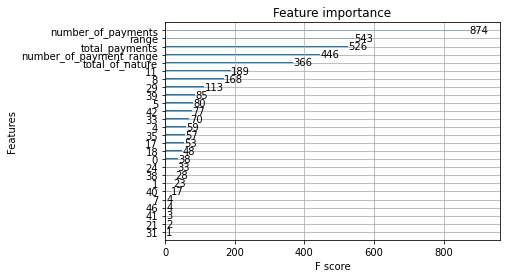

In [214]:
# feature importance plot
xgb.plot_importance(xgbc_opt)
plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

# Logistic Regression Model

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem  
  
Estimation: Maximum Likelihood

In [215]:
# creating a logistic regression classifier object 
log_reg = LogisticRegression()

In [ ]:
# gridsearch to optimize the logistic regression model
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_gridsearch = GridSearchCV(log_reg, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_gridsearch.fit(X_train , y_train)
LR_gridsearch.best_params_


Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. Th

[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=0.001, max_iter=100, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=0.001, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=0.001, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=200, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=200, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=0.001, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=300, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=300, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.001, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=400, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=400, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.001, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=500, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=500, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.001, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=600, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=600, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l1, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=0.001, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.001, max_iter=700, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l2, solver=lbfgs .................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l2, solver=liblinear .............
[CV]  C=0.001, max_iter=700, penalty=l2, solver=liblinear, score=0.939, total=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=sag ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.001, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=saga ..................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=0.001, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=100, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=0.01, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=0.01, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=200, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=0.01, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=lbfgs, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=300, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.01, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.01, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=400, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.01, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=500, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.01, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=600, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  C=0.01, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=0.01, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.01, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=0.01, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, max_iter=700, penalty=l2, solver=liblinear, score=0.938, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.01, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=0.01, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=0.1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=0.1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=0.1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=300, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=400, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=500, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=0.1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=600, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=sag .....................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=0.1, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWa

[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.5s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=0.1, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, max_iter=700, penalty=l2, solver=liblinear, score=0.940, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=0.1, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1, max_iter=100, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1, max_iter=

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=1, max_iter=100, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=100, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=1

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=1, max_iter=200, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=200, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=200, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=200, pe

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=200, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=200, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=200, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=200, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=200, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=200, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=200, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=200, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=300, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=300,

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.944, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l1, solver=sa

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=300, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=300, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=300, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=300, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=300, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=300, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=300, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=3

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=300, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=1, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=400, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1, max_iter=40

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=400, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=400, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=400, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=400, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=400, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=400, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=4

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=1, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1, max_iter=400, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1, max_iter=500, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=500, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=500, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=500, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=500, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=5

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=500, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=500, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=500, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=500, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=500, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=500, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=500, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=5

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1, max_iter=500, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=1, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1, max_iter=600, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=600, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=600, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=600, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=600, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=6

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=600, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=600, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=600, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=600, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=600, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=600, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=600, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=6

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=sag .......................
[CV]  C=1, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1, max_iter=700, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=700, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=700, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=700, penalty=l1, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, max_iter=700,

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear

[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1, max_iter=700, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1, max_iter=700, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=700, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1, max_iter=700, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1, max_iter=700, penalty=l2, solver=lbfgs .....................
[CV]  C=1, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1, max_iter=700, penalty=l2, solver=liblinear .................
[CV]  C=1, max_iter=700, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=1, max_iter=7

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=sag .......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=saga ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=1, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=100, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, max_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=10, max_iter=100, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=100, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=10, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=10, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=10, max_iter=200, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=200, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=200, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=200, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=200, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=200, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=200, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=200, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=200, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=10, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=200, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=10, max_iter=300, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=300, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=300, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=300, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_i

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=300, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=300, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=300, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=300, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=300, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=300, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=300, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=10, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=300, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=10, max_iter=400, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=400, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=400, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=400, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=400, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=400, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=400, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=400, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=400, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=400, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=400, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=10, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=10, max_iter=400, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=10, max_iter=500, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=500, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=500, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=500, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=500, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=500, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=500, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=500, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=500, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=500, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=500, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=500, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=10, max_iter=500, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=10, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=500, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=600, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=600, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=600, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=600, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=600, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=600, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=600, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=600, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=600, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=600, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=600, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=600, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=sag ......................
[CV]  C=10, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=saga .....................
[CV]  C=10, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=10, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=10, max_iter=700, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, max

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=10, max_iter=700, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=10, max_iter=700, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=700, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=10, max_iter=700, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=10, max_iter=700, penalty=l2, solver=lbfgs ....................
[CV]  C=10, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=10, max_iter=700, penalty=l2, solver=liblinear ................
[CV]  C=10, max_iter=700, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C=10, ma

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=sag ......................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=10, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=saga .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=10, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=100, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=100, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=100, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=200, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=200, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=200, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=100, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=100, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=300, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=300, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=300, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=100, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=400, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=400, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=400, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=400, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=100, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=100, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=500, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=500, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=500, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=500, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=100, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=600, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=600, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=600, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=600, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=sag .....................
[CV]  C=100, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=100, max_iter=700, penalty=l1, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=100, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=1

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=100, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=100, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=100, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=100, max_iter=700, penalty=l2, solver=lbfgs ...................
[CV]  C=100, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=100, max_iter=700, penalty=l2, solver=liblinear ...............
[CV]  C=100, max_iter=700, penalty=l2, solver=liblinear, score=0.941, total=   0.0s
[CV] C

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=sag .....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=100, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=saga ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=100, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.939, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.940, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iter

[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.938, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.944, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=100, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=100, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[CV]  C=1000, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l2, solver=sag, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l2, solver=sag, score=0.939, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition fo

[CV]  C=1000, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l2, solver=saga, score=0.940, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l2, solver=saga, score=0.939, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=200, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=200, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=200, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=200, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=200, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



[CV] C=1000, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=200, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=200, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_s

[CV]  C=1000, max_iter=200, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=200, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.939, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=300, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=300, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=300, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=300, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=300, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=300, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=300, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=1000, max_iter=300, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=300, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.941, total=   0.3s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=400, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=400, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=400, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=400, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=400, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=400, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l2, solver=sag, score=0.939, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=1000, max_iter=400, penalty=l2, solver=saga, score=0.940, total=   0.1s
[CV] C=1000, max_iter=400, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l2, solver=saga, score=0.939, total=   0.1s
[CV] C=1000, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



[CV]  C=1000, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=500, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=500, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=500, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=500, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=500, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=500, penalty=l2, solver=sag, score=0.940, total=   0.1s
[CV] C=1000, max_iter=500, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'no

[CV]  C=1000, max_iter=500, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=newton-cg, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=600, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=600, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=600, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=600, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=600, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=600, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test parti

[CV]  C=1000, max_iter=600, penalty=l2, solver=saga, score=0.939, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l1, solver=lbfgs, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.940, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.939, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.941, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.940, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.938, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.944, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l2, solver=lbfgs, score=0.939, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l2, solver=lbfgs, score=0.934, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l2, solver=lbfgs, score=0.936, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l2, solver=lbfgs ..................
[CV]  C=1000, max_iter=700, penalty=l2, solver=lbfgs, score=0.935, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l2, solver=liblinear ..............
[CV]  C=1000, max_iter=700, penalty=l2, solver=liblinear, score=0.941, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=sag ....................
[CV]  C=1000, max_iter=700, penalty=l2, solver=sag, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=sag ....................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=sag, score=0.939, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=saga ...................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1000, max_iter=700, penalty=l2, solver=saga, score=0.940, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=saga ...................
[CV]  C=1000, max_iter=700, penalty=l2, solver=saga, score=0.939, total=   0.2s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 2450 out of 2450 | elapsed:  3.4min finished


NameError: ignored

In [ ]:
# summarize
print('Mean Accuracy: %.3f' % LR_gridsearch.best_score_)
print('Config: %s' % LR_gridsearch.best_params_)

Mean Accuracy: 0.940
Config: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# optimal logistic regression model
# C: inverse of regularization strength, 
# solver: algorithm used for optimization problem, 
# penalty: norm used in the penalization term (l1 vs l2)
# max_iter: maximum no. of iterations for the solver to converge
log_reg_opt = LogisticRegression(C= 1, max_iter= 100, penalty= 'l2', solver='liblinear')

In [ ]:
# fitting the logistic regression model to the training data (LR model with gridsearch)
log_reg_opt.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predicting on the test set
y_pred_lr_opt = log_reg_opt.predict(X_test)

In [ ]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_lr_opt, return_counts=True)

(array([0, 1]), array([782,   5]))

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_lr_opt)

0.9415501905972046

In [216]:
# fitting the logistic regression model to the training data (regular LR model without gridsearch)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [217]:
# predicting on the test set
y_pred_lr = log_reg.predict(X_test)

In [218]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_lr, return_counts=True)

(array([0, 1]), array([779,   9]))

In [219]:
y_pred_lr.shape

(788,)

Model evaluation

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_lr)

0.9415501905972046

In [220]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_lr)

0.5062587794599657

In [221]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_lr)

conf_matrix

array([[737,   8],
       [ 42,   1]])

The Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity

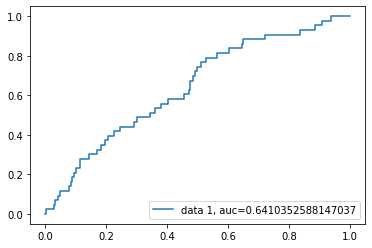

In [ ]:
# Plotting the Receiver Operator Curve (ROC)
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

In [ ]:
# initializing a Gaussian Naive Bayes Classifier
gnb = GaussianNB()

In [ ]:
# fitting the model to the training data
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# obtaining predictions
y_pred_nb = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
% (X_test.shape[0], (y_test != y_pred_nb).sum()))

Number of mislabeled points out of a total 787 points : 62


In [ ]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_nb, return_counts=True)

(array([0, 1]), array([762,  25]))

Model Evaluation

In [ ]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_nb)

0.5200987746936734

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_nb)

0.9212198221092758

In [ ]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_nb)

conf_matrix

array([[722,  22],
       [ 40,   3]])

# Final model with all Training data for Server submission

In [331]:
# we train a final model on 5000 data points
# labels 
y_train = train_final["ownership_interest"]


# y_test is unknown

print(y_train)

0       0
1       0
2       0
3       0
4       0
       ..
4784    0
4785    0
4786    0
4787    0
4788    0
Name: ownership_interest, Length: 4789, dtype: int64


In [332]:
# features (manually) 5000 data points
X_train = train_final.drop(["ownership_interest"], axis=1)
X_train = X_train[enc_features]

# 1000 data points for test set features
X_test = test_final
print(X_train, X_test)

print(X_train.shape, X_test.shape)

      total_payments  ...  x1_Travel and Lodging
0             952.93  ...                    0.0
1          120924.92  ...                    0.0
2            3523.93  ...                    0.0
3           26745.61  ...                    0.0
4           25411.21  ...                    0.0
...              ...  ...                    ...
4784         5528.35  ...                    0.0
4785        19714.41  ...                    0.0
4786         2946.90  ...                    0.0
4787         7870.54  ...                    0.0
4788         5779.80  ...                    0.0

[4789 rows x 43 columns]      Physician_ID  total_payments  ...  x1_Royalty or License  x1_Travel and Lodging
0              14         5775.53  ...                    0.0                    0.0
1              18        92123.24  ...                    0.0                    0.0
2              42         3159.49  ...                    0.0                    0.0
3              46         1614.34  ...        

In [315]:
X_train.columns

Index(['x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers', 'x0_Dermatology',
       'x0_Emergency Medicine', 'x0_Eye and Vision Services Providers',
       'x0_Family Medicine', 'x0_General Practice', 'x0_Hospitalist',
       'x0_Internal Medicine', 'x0_Neurological Surgery',
       'x0_Obstetrics & Gynecology', 'x0_Ophthalmology',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program',
       'x1_Compensation for se

In [316]:
X_test.columns

Index(['Physician_ID', 'total_payments', 'number_of_payments',
       'total_of_nature', 'range', 'number_of_payment_range',
       'x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers', 'x0_Dermatology',
       'x0_Emergency Medicine', 'x0_Eye and Vision Services Providers',
       'x0_Family Medicine', 'x0_General Practice', 'x0_Hospitalist',
       'x0_Internal Medicine', 'x0_Neurological Surgery',
       'x0_Obstetrics & Gynecology', 'x0_Ophthalmology',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, inclu

Fitting an XGBClassifier model on 5000 data points

In [333]:
# count # of examples/data points in each class
counter = Counter(y_train)

counter


Counter({0: 4505, 1: 284})

In [334]:
# estimate scale_pos_weight value, assuming the class labels are 0 and 1
weight = counter[0] / counter[1]

weight


15.862676056338028

In [335]:
# initilizing the XGBClassifier as an object: (using all the default hyperparameters)
# here we initialize an XGBClassifier with a scale_pos_weight for imbalanced classification data
xgbc = xgb.XGBClassifier(scale_pos_weight= weight)



In [336]:
# CV type 2: stratified k-fold CV (due to imbalance in the data set) -> maintains the ratio of instances in each class for each fold
skfold = StratifiedKFold(n_splits=5, shuffle=False) 

In [337]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=skfold,scoring='balanced_accuracy')
print("Stratified K-fold CV average score: %.2f" % clf_cv_scores.mean())

clf_cv_scores # score per fold


Stratified K-fold CV average score: 0.72


array([0.74554588, 0.74443601, 0.66837043, 0.72766127, 0.69298993])

In [280]:
# gridsearch cross validation (scoring parameter is used to set the loss function for the gscv)

xgbc_gscv = GridSearchCV(estimator = xgbc, scoring = 'balanced_accuracy', param_grid = {'colsample_by_tree':[0.8,1.0],'subsample':[0.8,1.0],"min_child_weight":[1.0], 'learning_rate': [0.1,0.01] , 'max_depth': [5,10], 'n_estimators': [100,200], 'lambda': [0.8,1], 'alpha':[0.8,1.0]}, verbose=1, cv = skfold, n_jobs=4)

In [281]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed: 17.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:...
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [0.8, 1.0], 'colsample_by_tree': [0.8, 1.0],
                         'lambda': [0.8, 1], 'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 10], 'min_child_we

In [283]:
# obtaining the best hyperparameter values from the gridsearch cv
xgbc_gscv.best_params_

{'alpha': 0.8,
 'colsample_by_tree': 0.8,
 'lambda': 0.8,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1.0,
 'n_estimators': 200,
 'subsample': 1.0}

In [284]:
print(xgbc_gscv.scoring, xgbc_gscv.best_score_)

balanced_accuracy 0.7011310184451138


In [285]:
xgbc_gscv.best_estimator_

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree',
              colsample_by_tree=0.8, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, gamma=0, lambda=0.8, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1.0, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=15.862676056338028, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [338]:
# setting up the optimal xgb classifier model using the configuration of hyperparameters from the gscv
xgbc_opt = xgb.XGBClassifier(objective="binary:logistic", obj="balanced_accuracy", feval = "balanced_accuracy", scale_pos_weight = weight, booster="gbtree",learning_rate=0.01, colsample_bytree=0.8, max_depth=5, min_child_weight=1.0,n_estimators = 200, subsample = 1.0, alpha =0.8, reg_lambda=0.8)

In [339]:
# fitting the XGB classifier model to the training data (final model with optimal hyperparameters from the gscv)
xgbc_opt.fit(X_train, y_train)

XGBClassifier(alpha=0.8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              feval='balanced_accuracy', gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1.0, missing=None,
              n_estimators=200, n_jobs=1, nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.8, scale_pos_weight=15.862676056338028, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [340]:
# dropping the dummy column not present in the training data but in the test data
test_final = test_final.drop(["x0_Phlebology"], axis=1)

KeyError: ignored

In [341]:
# making predictions using the test data
y_pred_xgbc = xgbc_opt.predict(test_final.drop(["Physician_ID"],axis=1))


In [342]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_xgbc, return_counts=True)


(array([0, 1]), array([799, 201]))

# Exporting the predicitions for a submission

Export predictions into csv file  
• Format: id, prediction  
• Predictions must be 0 or 1 (not 0.5, not ‘Yes’, not ‘FALSE’)  
• Must contain all instances of the original test dataset

In [282]:
test_final.columns

Index(['Physician_ID', 'total_payments', 'number_of_payments',
       'total_of_nature', 'range', 'number_of_payment_range',
       'x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers', 'x0_Dermatology',
       'x0_Emergency Medicine', 'x0_Eye and Vision Services Providers',
       'x0_Family Medicine', 'x0_General Practice', 'x0_Hospitalist',
       'x0_Internal Medicine', 'x0_Neurological Surgery',
       'x0_Obstetrics & Gynecology', 'x0_Ophthalmology',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics', 'x0_Phlebology',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than 

In [343]:
final_preds = y_pred_xgbc

In [344]:
# storing the ids and the corresponding predictions as a combined dataframe

submission = pd.DataFrame()

submission["id"] = test_final["Physician_ID"]

submission["prediction"] = final_preds


submission



,id,prediction
0,14,1
1,18,0
2,42,0
3,46,0
4,47,0
...,...,...
995,5953,0
996,5959,1
997,5964,0
998,5972,1


In [345]:
# storing the submission data in a csv file
submission.to_csv('submission_3_team_sgs.csv', index=False) 

In [346]:
from google.colab import files
files.download("submission_3_team_sgs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>